In [12]:
import os
from datasets import load_dataset
import torch
import torchaudio
from transformers import AutoProcessor, AutoModel
import numpy as np
from panns_inference import AudioTagging

In [ ]:

# Load the dataset
dataset = load_dataset("lewtun/music_genres_small")

# Check a sample

samples = dataset['train'][0]
print(samples)

{'audio': {'path': None, 'array': array([-3.29642924e-10, -4.74537076e-10,  1.09266698e-08, ...,
       -2.98384890e-01, -3.06825116e-01, -2.82902196e-01]), 'sampling_rate': 44100}, 'song_id': 11704, 'genre_id': 6, 'genre': 'Chiptune / Glitch'}


In [30]:
# Load PANNs model (Cnn14)
model = AudioTagging(checkpoint_path=None, device='cuda')  # Use 'cuda' if you have a GPU

def extract_embeddings(audio_sample):
    """Extract embeddings from a dataset sample."""
    waveform = torch.tensor(audio_sample["audio"]["array"]).float().unsqueeze(0).to("cuda")  # Convert to FloatTensor & move to GPU
    with torch.no_grad():
        embedding, _ = model.inference(waveform)  # ✅ Unpack tuple: (embedding, class_probabilities)
    return embedding  # ✅ Returns the correct feature embeddings

def extract_and_save_embeddings(dataset, save_path="embeddings-for-instruments-task.npy"):
    embeddings = []
    for sample in dataset:
        embeddings.append(extract_embeddings(sample))
    np.save(save_path, np.array(embeddings))
    return save_path

embedding_file = extract_and_save_embeddings(dataset['train'])



Checkpoint path: C:\Users\Prosp/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1


In [42]:
# Load PANNs model (Cnn14)
model = AudioTagging(checkpoint_path=None, device='cuda')  # Use 'cuda' if you have a GPU

def extract_embeddings(audio_sample):
    """Extract embeddings from a dataset sample."""
    waveform = torch.tensor(audio_sample["audio"]["array"]).float().unsqueeze(0).to("cuda")  # Convert to FloatTensor & move to GPU
    with torch.no_grad():
        embedding, _ = model.inference(waveform)  # ✅ Unpack tuple: (embedding, class_probabilities)
    return embedding  # ✅ Returns the correct feature embeddings

def extract_and_save_embeddings(dataset, save_path="embeddings-for-instruments-task.npz"):
    embeddings = []
    for sample in dataset:
        embeddings.append(extract_embeddings(sample))
    np.save(save_path, np.array(embeddings))
    return save_path

embedding_file = extract_and_save_embeddings(dataset['train'])



Checkpoint path: C:\Users\Prosp/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1


In [37]:
# Load embeddings
embeddings = np.load("embeddings-for-instruments-task.npy")

# Remove the extra dimension
embeddings = np.squeeze(embeddings)  # Shape will become (1000, 527)

# Check new shape
print(embeddings.shape)  # Should print (1000, 527)

(1000, 527)


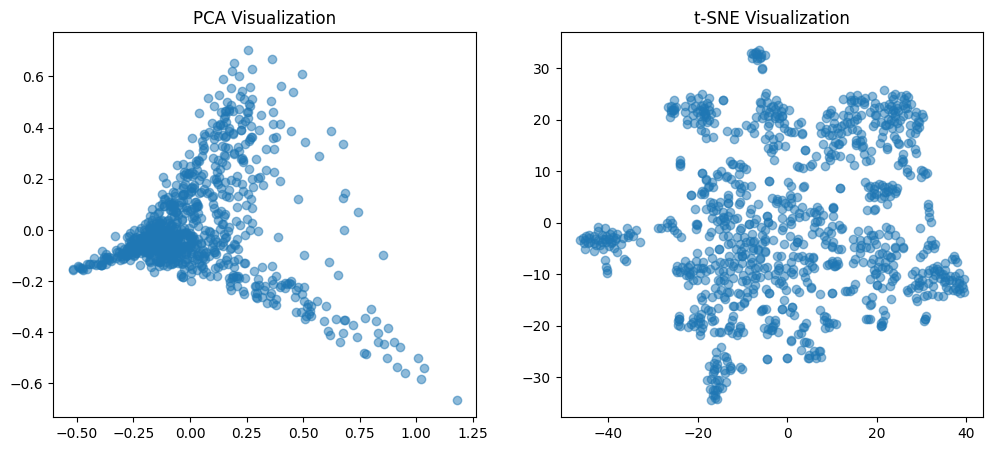

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load embeddings
embeddings = np.squeeze(np.load("embeddings-for-instruments-task.npy"))  # Shape: (num_samples, embedding_dim)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.5)
plt.title("PCA Visualization")

# Plot t-SNE
plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
plt.title("t-SNE Visualization")

plt.show()


In [93]:
# 1. Reload the dataset to get labels
dataset = load_dataset("lewtun/music_genres_small")
train_data = dataset['train']

# 2. Load your saved embeddings
embeddings = np.load("embeddings-for-instruments-task.npy")
embeddings = np.squeeze(embeddings)  # Shape (1000, 527)

# 3. Verify the order is preserved (critical!)
assert len(embeddings) == len(train_data), "Mismatch between embeddings and dataset length"

# 4. Extract labels in the same order as embeddings were generated
labels = [sample['genre'] for sample in train_data]

# 5. Now you have parallel arrays:
# - embeddings[i] corresponds to labels[i]
print(f"First 5 labels: {labels[:5]}")
print(f"First embedding shape: {embeddings[0].shape}")

First 5 labels: ['International', 'International', 'Pop', 'International', 'Electronic']
First embedding shape: (527,)


In [97]:
def extract_and_save_embeddings_with_labels(dataset, save_prefix="music_genre"):
    embeddings = []
    labels = []
    
    for sample in dataset:
        embeddings.append(extract_embeddings(sample))
        labels.append(sample['genre'])
    
    # Save as numpy arrays
    np.save(f"{save_prefix}_embeddings.npy", np.array(embeddings))
    np.save(f"{save_prefix}_labels.npy", np.array(labels))
    
    # Alternative: Save as dictionary in npz format
    np.savez(f"{save_prefix}_data.npz", embeddings=embeddings, labels=labels)
    
    return embeddings, labels



In [98]:
# Usage
embeddings, labels = extract_and_save_embeddings_with_labels(dataset['train'])
embeddings = np.squeeze(embeddings)

AttributeError: 'GenreClassifier' object has no attribute 'inference'

In [100]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 1. Encode string labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# 2. Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    embeddings,
    encoded_labels,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels  # Important for imbalanced datasets
)


In [101]:
# 3. Now you can train your classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# 4. Evaluate
accuracy = clf.score(X_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")

# To get back original genre names:
predicted_genres = label_encoder.inverse_transform(clf.predict(X_test))

Test accuracy: 0.51


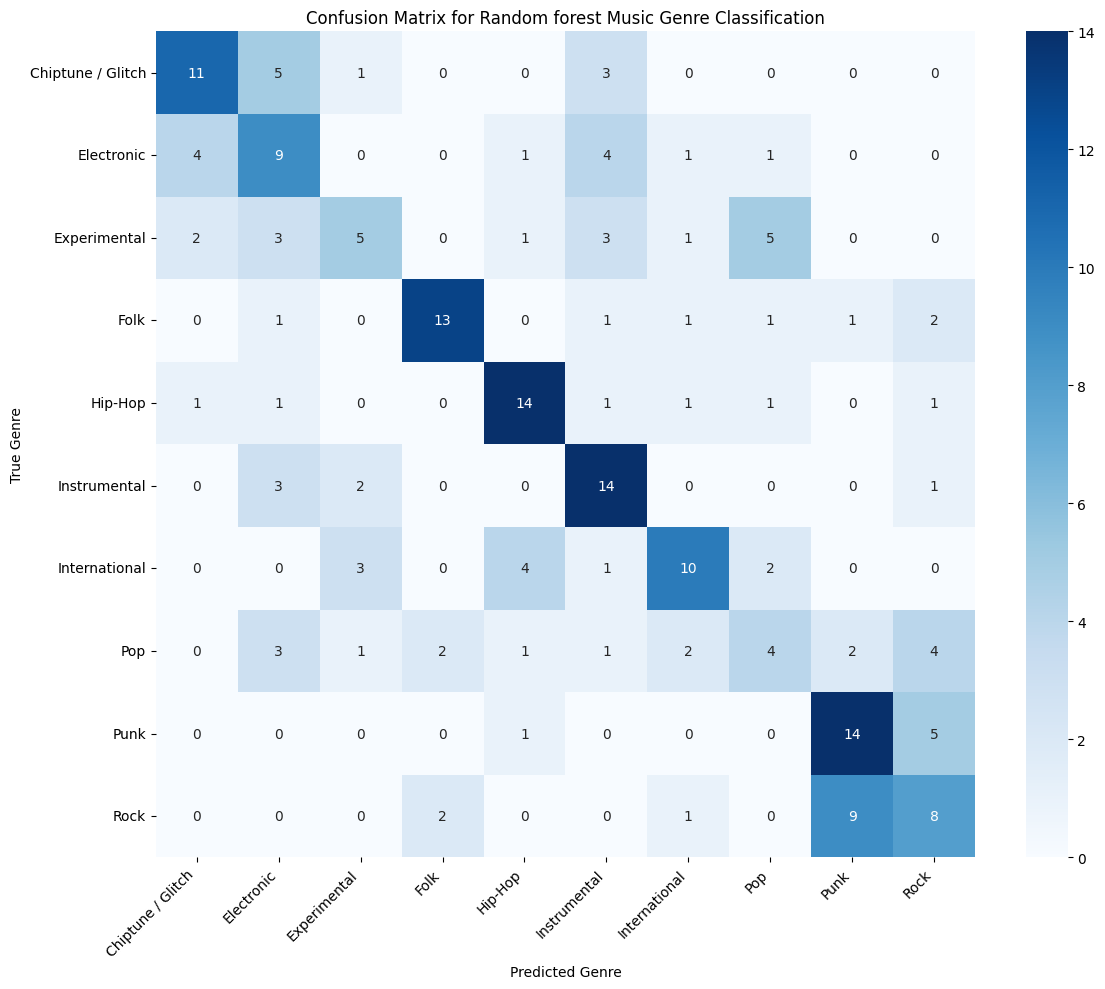

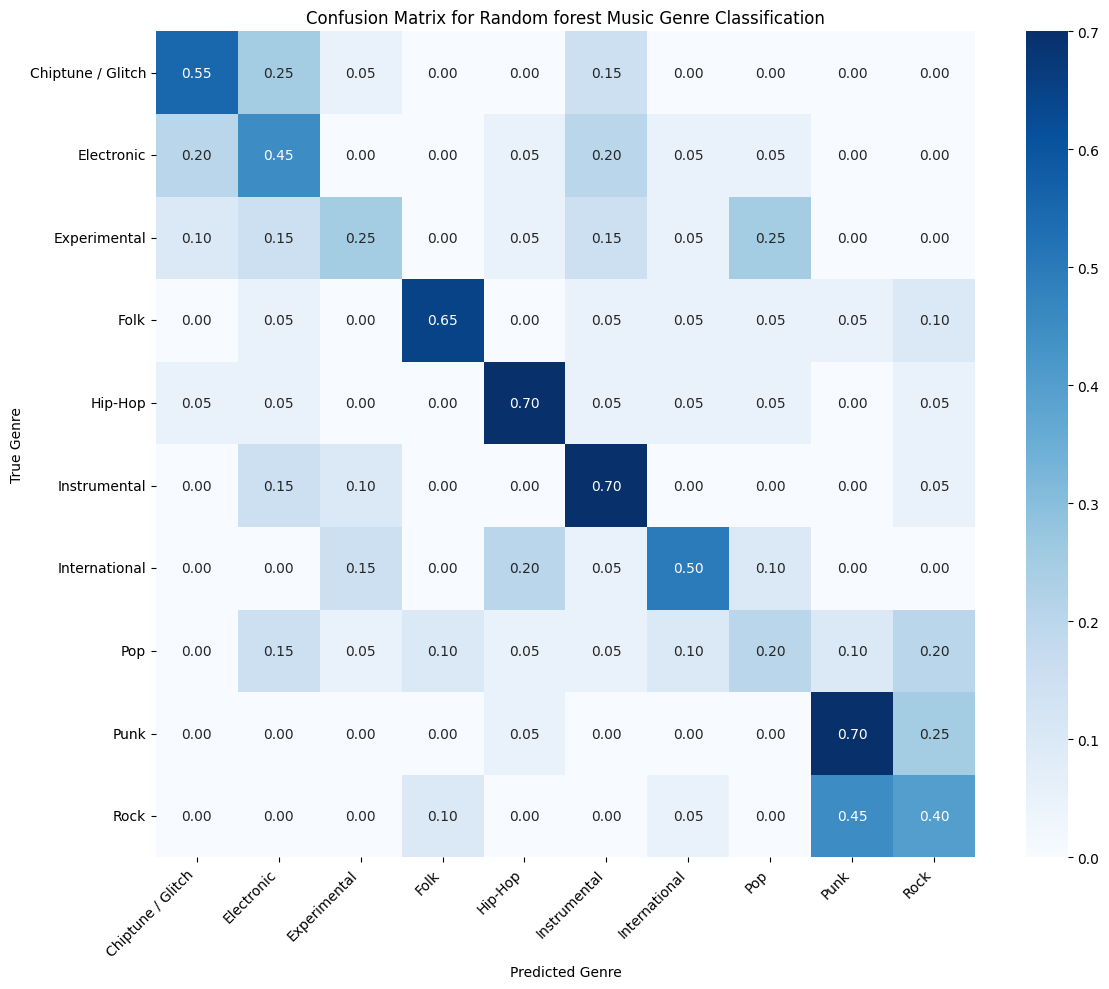

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = clf.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get class names in original string format
class_names = label_encoder.classes_

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix for Random forest Music Genre Classification')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Confusion Matrix for Random forest Music Genre Classification')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [105]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test, 
    y_pred, 
    target_names=class_names
))

                   precision    recall  f1-score   support

Chiptune / Glitch       0.61      0.55      0.58        20
       Electronic       0.36      0.45      0.40        20
     Experimental       0.42      0.25      0.31        20
             Folk       0.76      0.65      0.70        20
          Hip-Hop       0.64      0.70      0.67        20
     Instrumental       0.50      0.70      0.58        20
    International       0.59      0.50      0.54        20
              Pop       0.29      0.20      0.24        20
             Punk       0.54      0.70      0.61        20
             Rock       0.38      0.40      0.39        20

         accuracy                           0.51       200
        macro avg       0.51      0.51      0.50       200
     weighted avg       0.51      0.51      0.50       200



KNN Test Accuracy: 0.43

Classification Report:
                   precision    recall  f1-score   support

Chiptune / Glitch       0.55      0.55      0.55        20
       Electronic       0.30      0.35      0.33        20
     Experimental       0.36      0.40      0.38        20
             Folk       0.52      0.70      0.60        20
          Hip-Hop       0.60      0.60      0.60        20
     Instrumental       0.38      0.30      0.33        20
    International       0.50      0.30      0.38        20
              Pop       0.19      0.20      0.20        20
             Punk       0.48      0.65      0.55        20
             Rock       0.50      0.30      0.38        20

         accuracy                           0.43       200
        macro avg       0.44      0.43      0.43       200
     weighted avg       0.44      0.43      0.43       200



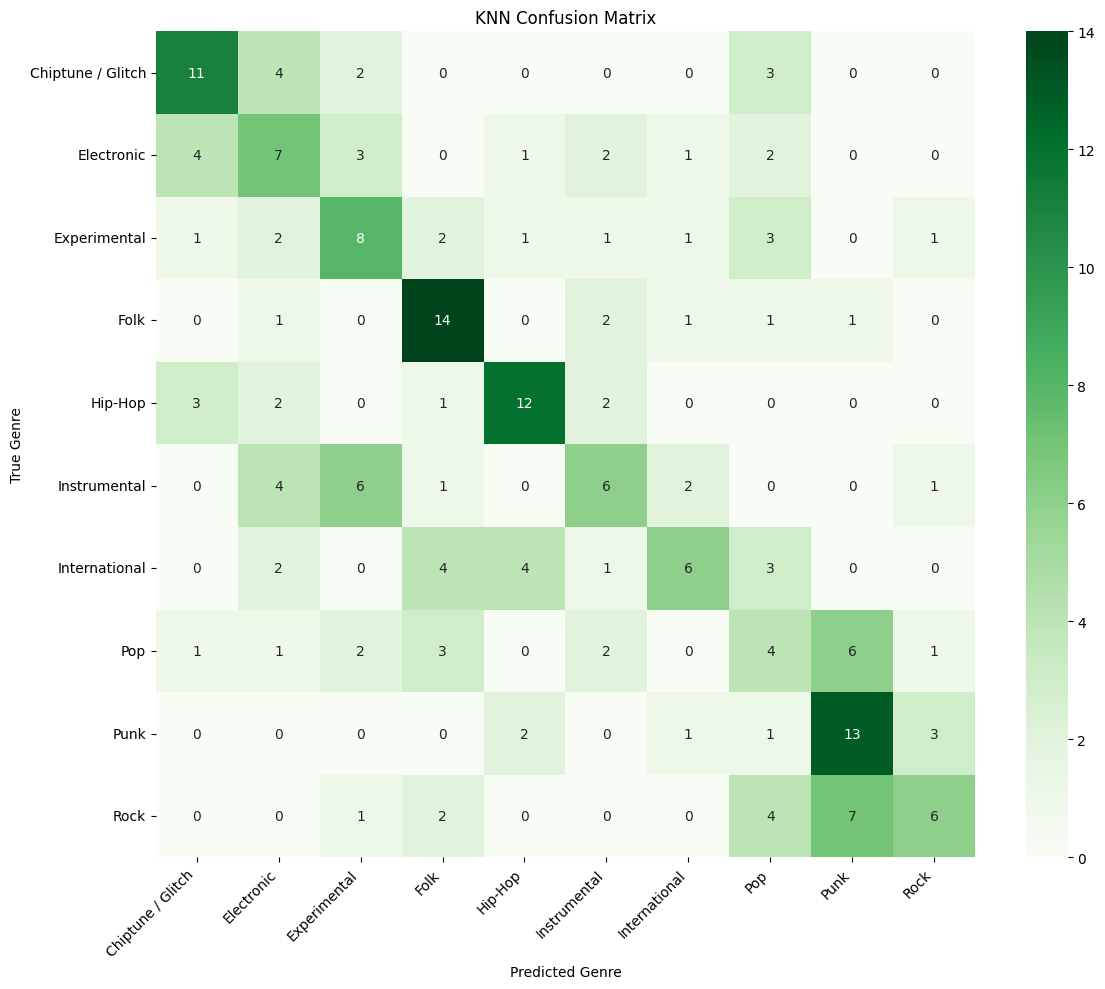


Model Comparison:
- Random Forest Accuracy: 0.53
- KNN Accuracy: 0.43


In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Initialize and train KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)  # You can adjust n_neighbors
knn.fit(X_train, y_train)

## 2. Make predictions
y_pred_knn = knn.predict(X_test)

## 3. Evaluate performance
# Accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"KNN Test Accuracy: {knn_accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))

## 4. Plot confusion matrix
plt.figure(figsize=(12, 10))
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Compare with Random Forest
print("\nModel Comparison:")
print(f"- Random Forest Accuracy: {accuracy:.2f}")
print(f"- KNN Accuracy: {knn_accuracy:.2f}")

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

## 2. Create PyTorch Dataset
class GenreDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

train_dataset = GenreDataset(X_train, y_train)
test_dataset = GenreDataset(X_test, y_test)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 3. Define Deep Model Architecture
class GenreClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(GenreClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

# Initialize model
input_dim = embeddings.shape[1]
model = GenreClassifier(input_dim, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## 4. Training Setup
criterion = nn.CrossEntropyLoss()
# New SGD with momentum optimizer:
optimizer = optim.SGD(model.parameters(), 
                     lr=0.1,               # Typically higher than Adam's default
                     momentum=0.9,         # Helps accelerate in relevant direction
                     weight_decay=1e-4,    # Slightly stronger regularization
                     nesterov=True)        # Nesterov accelerated gradient

# Adjust the learning rate scheduler as needed
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    patience=5,      # Increased patience for SGD
    factor=0.5, 
    verbose=True
)
max_grad_norm = 1.0  # Common value, adjust as needed

## 5. Training Loop
def train_model(model, train_loader, test_loader, epochs=100):
    best_accuracy = 0
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()        
            
            running_loss += loss.item()
        
        # Validation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss/len(train_loader)
        epoch_test_loss = test_loss/len(test_loader)
        accuracy = 100 * correct / total
        
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        
        scheduler.step(epoch_test_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f} | "
              f"Accuracy: {accuracy:.2f}%")
        
        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "best_model.pth")
    
    return train_losses, test_losses


c:\Users\Prosp\.pyenv\pyenv-win\versions\3.11.6\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 2.0067 | Test Loss: 2.2677 | Accuracy: 12.00%
Epoch 2/100 | Train Loss: 1.5310 | Test Loss: 2.2124 | Accuracy: 12.00%
Epoch 3/100 | Train Loss: 1.4144 | Test Loss: 2.0359 | Accuracy: 19.00%
Epoch 4/100 | Train Loss: 1.3022 | Test Loss: 1.8208 | Accuracy: 35.00%
Epoch 5/100 | Train Loss: 1.2112 | Test Loss: 1.5761 | Accuracy: 44.50%
Epoch 6/100 | Train Loss: 1.2172 | Test Loss: 1.6339 | Accuracy: 45.00%
Epoch 7/100 | Train Loss: 1.1870 | Test Loss: 1.7599 | Accuracy: 46.00%
Epoch 8/100 | Train Loss: 1.1357 | Test Loss: 1.7899 | Accuracy: 48.00%
Epoch 9/100 | Train Loss: 1.1302 | Test Loss: 1.8890 | Accuracy: 42.00%
Epoch 10/100 | Train Loss: 1.1188 | Test Loss: 1.7848 | Accuracy: 42.50%
Epoch 11/100 | Train Loss: 1.0165 | Test Loss: 1.7635 | Accuracy: 49.50%
Epoch 12/100 | Train Loss: 0.9443 | Test Loss: 1.6967 | Accuracy: 45.50%
Epoch 13/100 | Train Loss: 0.9008 | Test Loss: 1.7813 | Accuracy: 47.00%
Epoch 14/100 | Train Loss: 0.9037 | Test Loss: 1.7836 | Accu

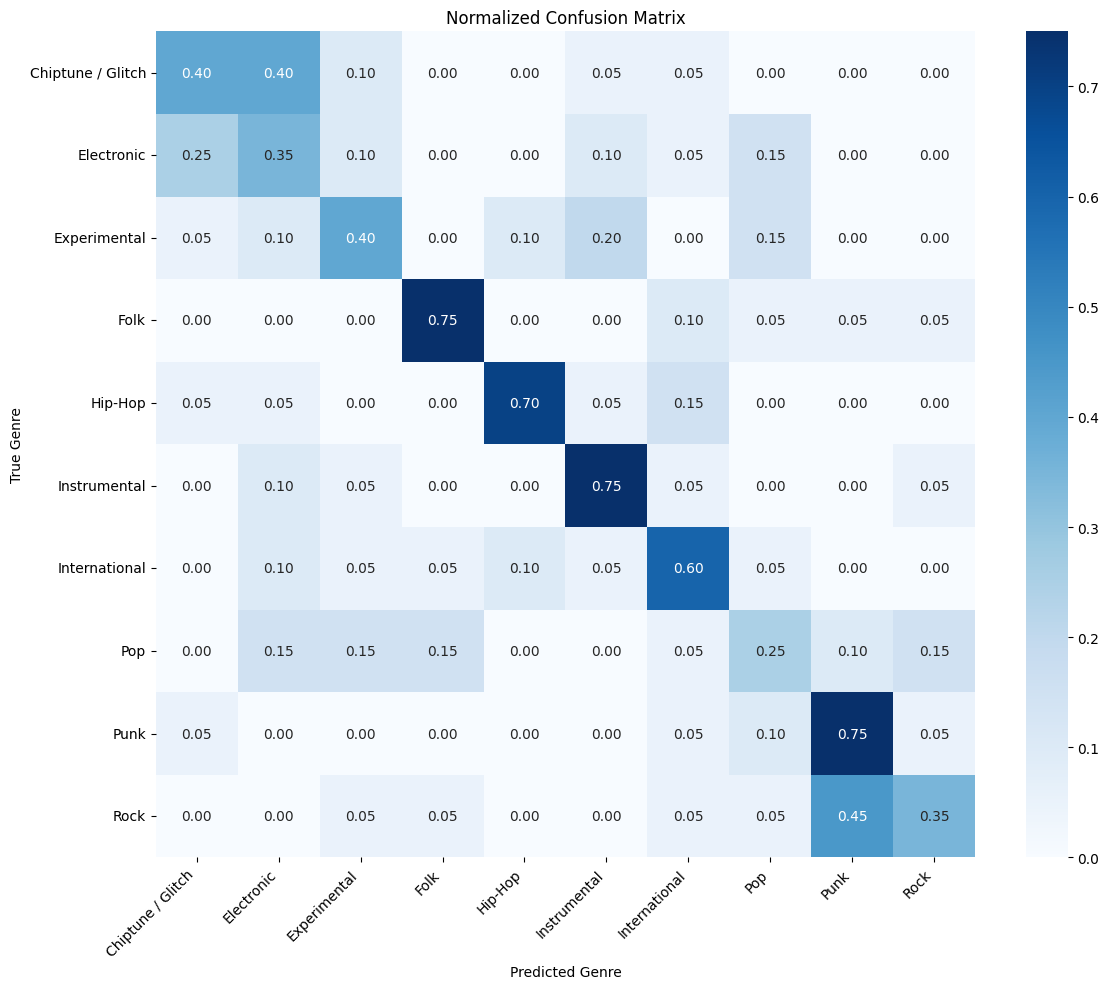

In [110]:
# Start training
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=100)

## 6. Evaluation and Confusion Matrix
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Genre")
    plt.ylabel("True Genre")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Load best model and plot confusion matrix
model.load_state_dict(torch.load("best_model.pth"))
plot_confusion_matrix(model, test_loader)

                   precision    recall  f1-score   support

Chiptune / Glitch       0.61      0.55      0.58        20
       Electronic       0.36      0.45      0.40        20
     Experimental       0.42      0.25      0.31        20
             Folk       0.76      0.65      0.70        20
          Hip-Hop       0.64      0.70      0.67        20
     Instrumental       0.50      0.70      0.58        20
    International       0.59      0.50      0.54        20
              Pop       0.29      0.20      0.24        20
             Punk       0.54      0.70      0.61        20
             Rock       0.38      0.40      0.39        20

         accuracy                           0.51       200
        macro avg       0.51      0.51      0.50       200
     weighted avg       0.51      0.51      0.50       200



In [66]:
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor
import torch
import torchaudio
import numpy as np
from datasets import load_dataset
from tqdm import tqdm

# Initialize model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "facebook/wav2vec2-base"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name).to(device)

def get_embeddings_from_audio(audio_array, sample_rate=16000):
    """Process raw audio array to get embeddings"""
    waveform = torch.tensor(audio_array).float()
    
    # Resample if necessary
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(
            orig_freq=sample_rate,
            new_freq=16000
        )
        waveform = resampler(waveform)
    
    # Process with feature extractor and model
    inputs = feature_extractor(
        waveform.numpy(), 
        sampling_rate=16000, 
        return_tensors="pt"
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Mean pooling over time dimension
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def extract_dataset_embeddings(dataset, batch_size=8):
    """Process entire dataset"""
    embeddings = []
    labels = []
    
    for i in tqdm(range(0, len(dataset)), desc="Extracting embeddings"):
        sample = dataset[i]
        
        # Get audio data and label
        audio_data = sample["audio"]["array"]
        sample_rate = sample["audio"]["sampling_rate"]
        label = sample["genre"]
        
        # Get embedding
        embedding = get_embeddings_from_audio(audio_data, sample_rate)
        
        embeddings.append(embedding)
        labels.append(label)
    
    # Stack all embeddings
    embeddings = np.vstack(embeddings)
    return embeddings, labels

In [67]:
# Usage example
embeddings_wav2vec, labels = extract_dataset_embeddings(dataset['train'])

# Save embeddings and labels
np.save("wav2vec2_embeddings.npy", embeddings_wav2vec)
np.save("wav2vec2_labels.npy", np.array(labels))

Extracting embeddings: 100%|██████████| 1000/1000 [10:04<00:00,  1.65it/s]


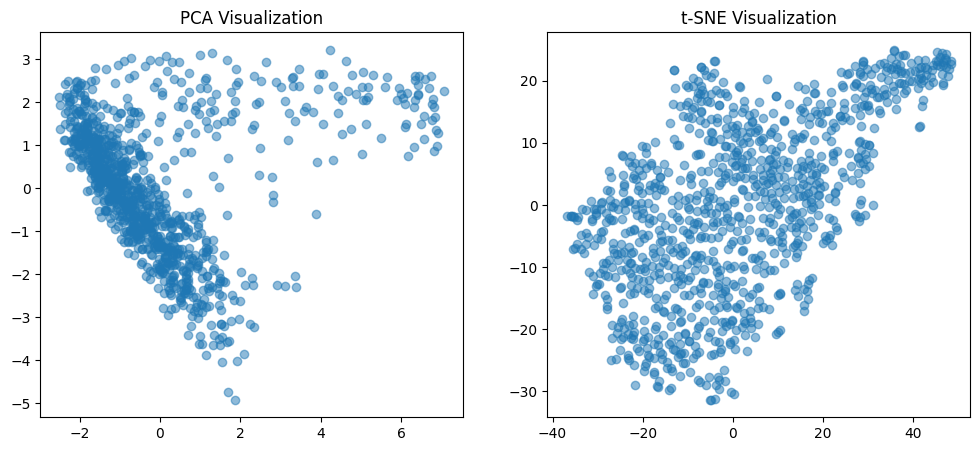

In [71]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_wav2vec)

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_wav2vec)

# Plot PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.5)
plt.title("PCA Visualization")

# Plot t-SNE
plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
plt.title("t-SNE Visualization")

plt.show()


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load saved embeddings if needed
# embeddings_wav2vec = np.load("wav2vec2_embeddings.npy")
# labels = np.load("wav2vec2_labels.npy")

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_wav2vec,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Train and evaluate
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3750


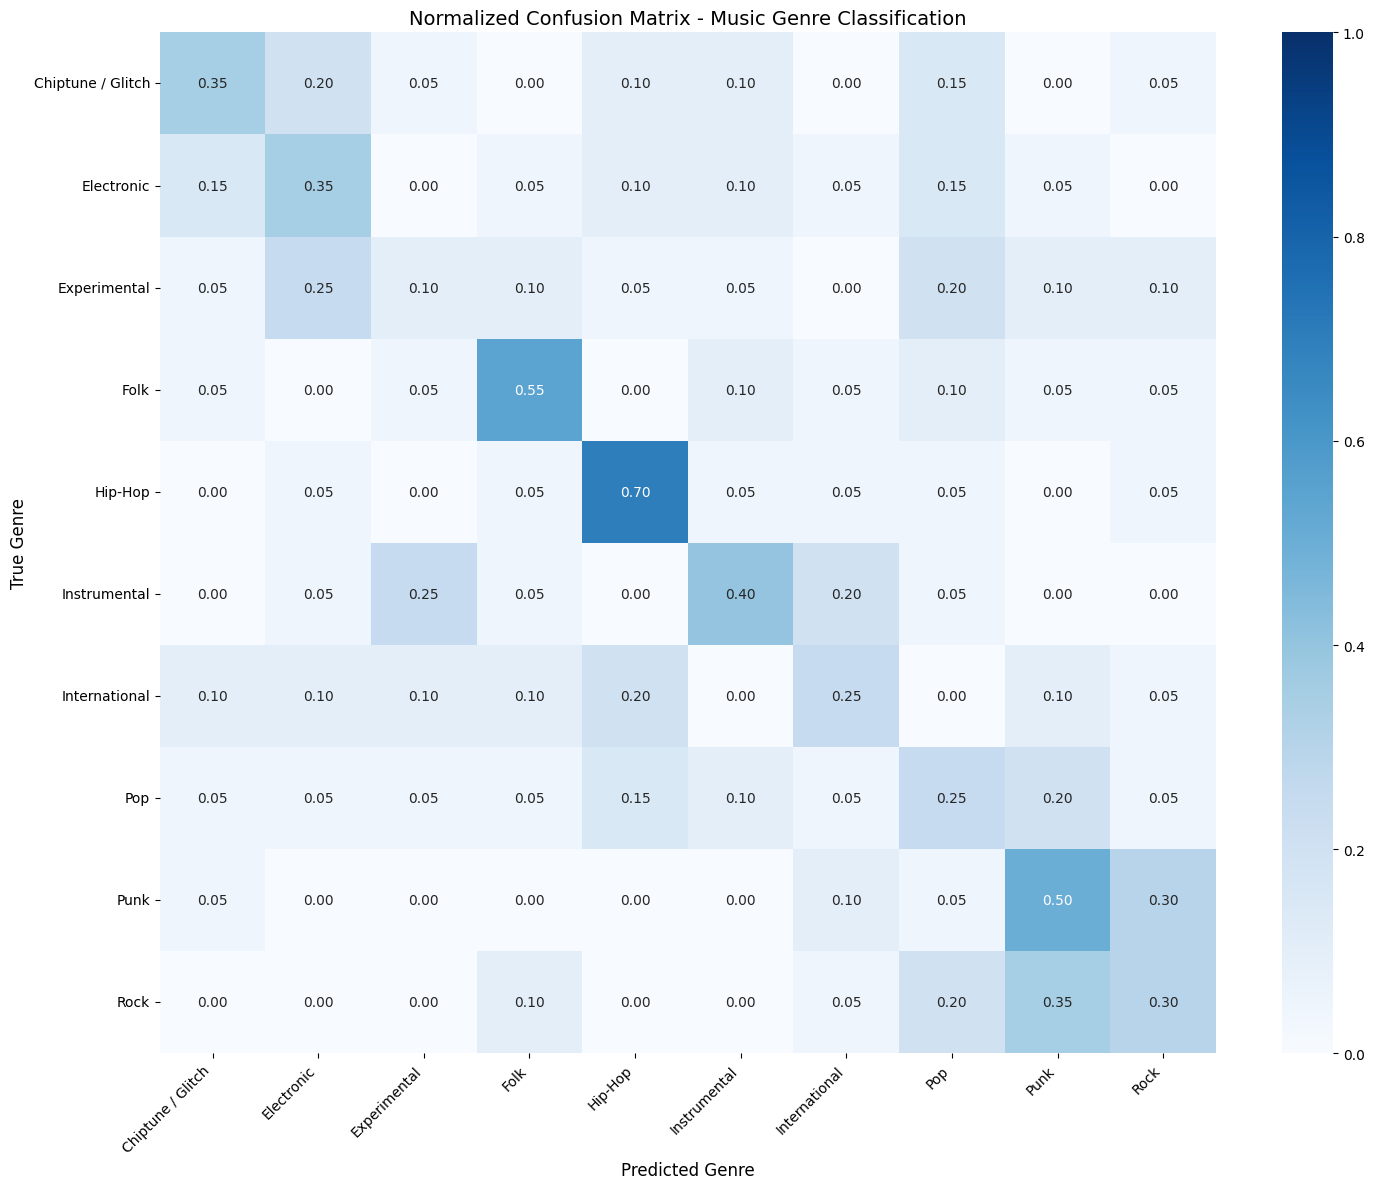

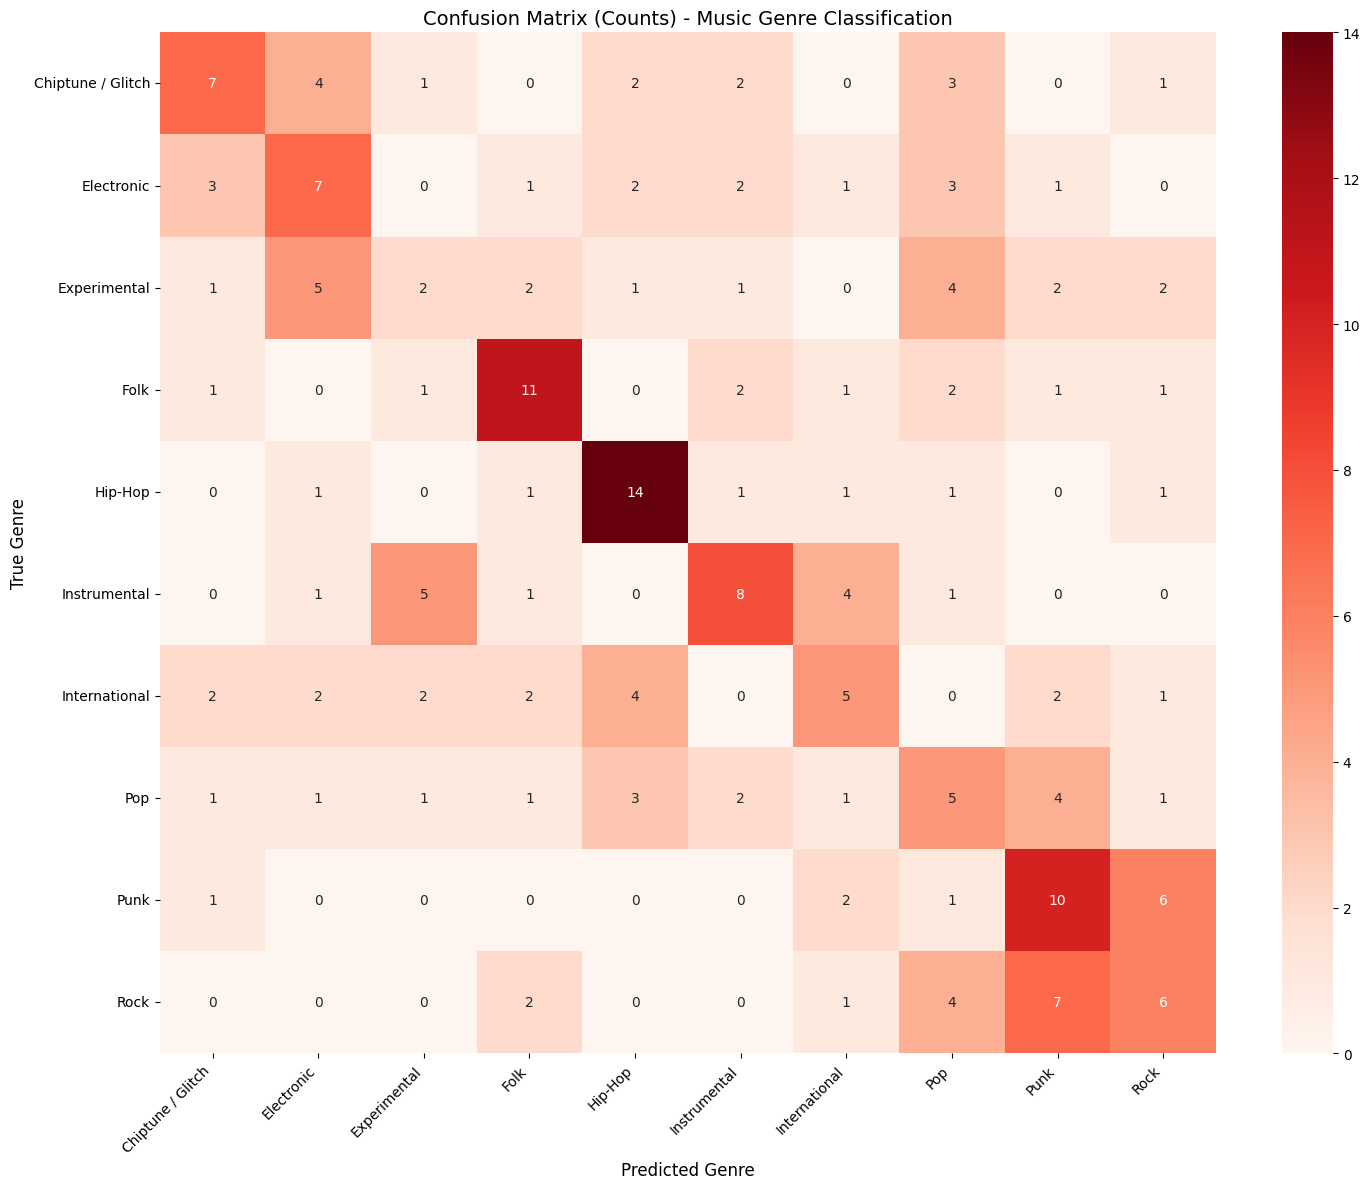

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have:
# - clf: your trained RandomForest classifier
# - X_test, y_test: test data
# - label_encoder: your LabelEncoder instance

# Get predictions
y_pred = clf.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get class names
class_names = label_encoder.classes_

# Create figure
plt.figure(figsize=(15, 12))

# Plot confusion matrix
sns.heatmap(cm_normalized, 
            annot=True, 
            fmt=".2f", 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            vmin=0, vmax=1)

# Add labels and title
plt.title('Normalized Confusion Matrix - Music Genre Classification', fontsize=14)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('True Genre', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Add colorbar
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

# Print raw numbers version
plt.figure(figsize=(15, 12))
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            cmap="Reds",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix (Counts) - Music Genre Classification', fontsize=14)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('True Genre', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [72]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test, 
    y_pred, 
    target_names=class_names
))

                   precision    recall  f1-score   support

Chiptune / Glitch       0.44      0.35      0.39        20
       Electronic       0.33      0.35      0.34        20
     Experimental       0.17      0.10      0.12        20
             Folk       0.52      0.55      0.54        20
          Hip-Hop       0.54      0.70      0.61        20
     Instrumental       0.44      0.40      0.42        20
    International       0.31      0.25      0.28        20
              Pop       0.21      0.25      0.23        20
             Punk       0.37      0.50      0.43        20
             Rock       0.32      0.30      0.31        20

         accuracy                           0.38       200
        macro avg       0.37      0.38      0.37       200
     weighted avg       0.37      0.38      0.37       200



KNN Test Accuracy: 0.34

Classification Report:
                   precision    recall  f1-score   support

Chiptune / Glitch       0.50      0.25      0.33        20
       Electronic       0.25      0.25      0.25        20
     Experimental       0.25      0.10      0.14        20
             Folk       0.35      0.45      0.39        20
          Hip-Hop       0.46      0.65      0.54        20
     Instrumental       0.38      0.15      0.21        20
    International       0.30      0.45      0.36        20
              Pop       0.29      0.25      0.27        20
             Punk       0.31      0.55      0.39        20
             Rock       0.29      0.25      0.27        20

         accuracy                           0.34       200
        macro avg       0.34      0.33      0.32       200
     weighted avg       0.34      0.34      0.32       200



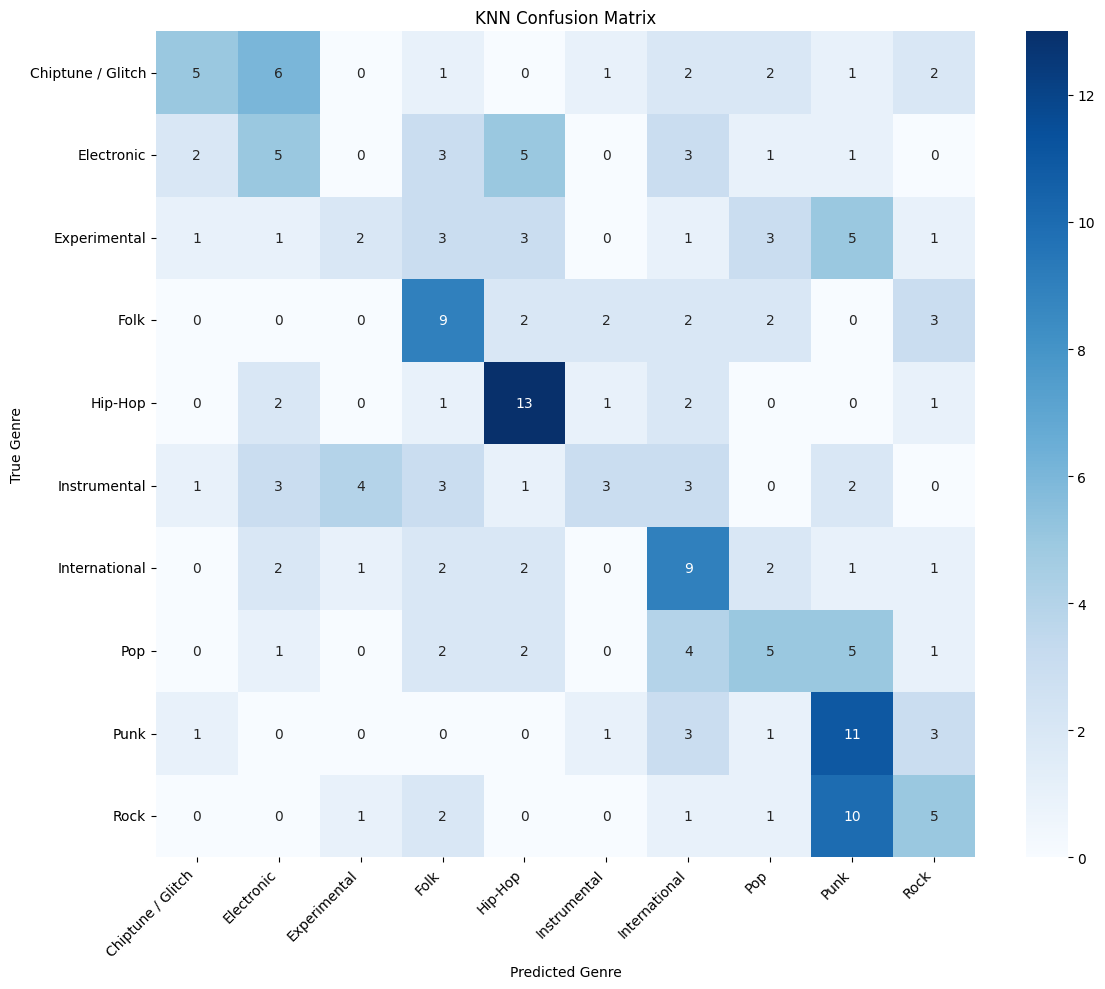


Model Comparison:
- Random Forest Accuracy: 0.38
- KNN Accuracy: 0.34


In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Initialize and train KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)  # You can adjust n_neighbors
knn.fit(X_train, y_train)

## 2. Make predictions
y_pred_knn = knn.predict(X_test)

## 3. Evaluate performance
# Accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"KNN Test Accuracy: {knn_accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))

## 4. Plot confusion matrix
plt.figure(figsize=(12, 10))
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Compare with Random Forest
print("\nModel Comparison:")
print(f"- Random Forest Accuracy: {accuracy:.2f}")
print(f"- KNN Accuracy: {knn_accuracy:.2f}")

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## 1. Prepare Data
# Load your saved embeddings and labels
embeddings = np.load("wav2vec2_embeddings.npy")
labels = np.load("wav2vec2_labels.npy")

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

## 2. Create PyTorch Dataset
class GenreDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

train_dataset = GenreDataset(X_train, y_train)
test_dataset = GenreDataset(X_test, y_test)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 3. Define Deep Model Architecture
class GenreClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(GenreClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

# Initialize model
input_dim = embeddings.shape[1]
model = GenreClassifier(input_dim, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## 4. Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

## 5. Training Loop
def train_model(model, train_loader, test_loader, epochs=100):
    best_accuracy = 0
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Validation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss/len(train_loader)
        epoch_test_loss = test_loss/len(test_loader)
        accuracy = 100 * correct / total
        
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        
        scheduler.step(epoch_test_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f} | "
              f"Accuracy: {accuracy:.2f}%")
        
        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "best_model.pth")
    
    return train_losses, test_losses


Epoch 1/100 | Train Loss: 0.5317 | Test Loss: 1.9634 | Accuracy: 45.50%
Epoch 2/100 | Train Loss: 0.5580 | Test Loss: 1.9647 | Accuracy: 44.50%
Epoch 3/100 | Train Loss: 0.5444 | Test Loss: 1.9709 | Accuracy: 44.50%
Epoch 4/100 | Train Loss: 0.5529 | Test Loss: 1.9745 | Accuracy: 45.00%
Epoch 5/100 | Train Loss: 0.5424 | Test Loss: 1.9704 | Accuracy: 45.00%
Epoch 6/100 | Train Loss: 0.5566 | Test Loss: 1.9672 | Accuracy: 43.50%
Epoch 7/100 | Train Loss: 0.5387 | Test Loss: 1.9678 | Accuracy: 44.50%
Epoch 8/100 | Train Loss: 0.5442 | Test Loss: 1.9662 | Accuracy: 44.50%
Epoch 9/100 | Train Loss: 0.5469 | Test Loss: 1.9655 | Accuracy: 45.50%
Epoch 10/100 | Train Loss: 0.5237 | Test Loss: 1.9625 | Accuracy: 46.00%
Epoch 11/100 | Train Loss: 0.5669 | Test Loss: 1.9603 | Accuracy: 44.50%
Epoch 12/100 | Train Loss: 0.5807 | Test Loss: 1.9610 | Accuracy: 44.50%
Epoch 13/100 | Train Loss: 0.5882 | Test Loss: 1.9717 | Accuracy: 44.00%
Epoch 14/100 | Train Loss: 0.5420 | Test Loss: 1.9613 | Accu

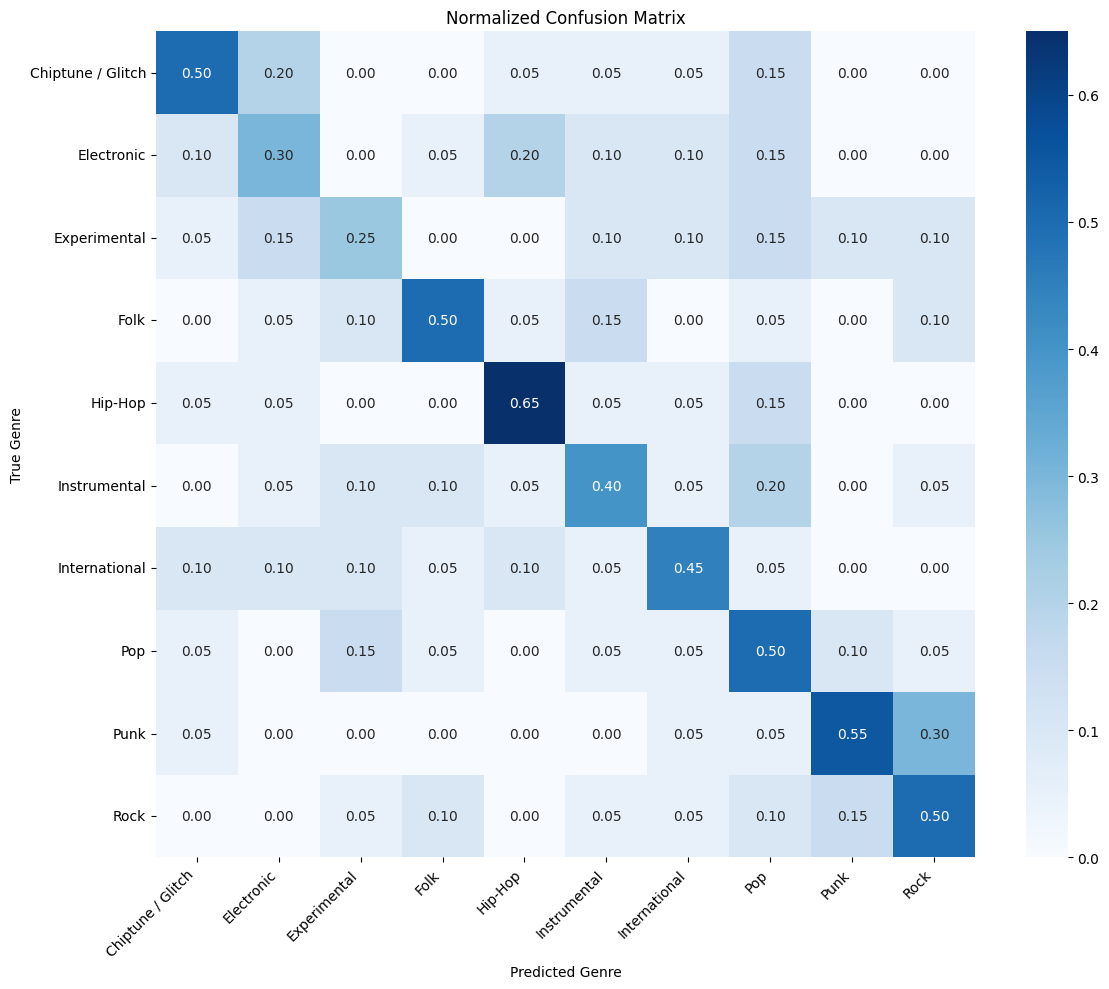

In [ ]:
# Start training
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=50)

## 6. Evaluation and Confusion Matrix
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Genre")
    plt.ylabel("True Genre")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Load best model and plot confusion matrix
model.load_state_dict(torch.load("best_model.pth"))
plot_confusion_matrix(model, test_loader)

In [ ]:
## Replace the optimizer section (keep everything else the same)

# Original Adam optimizer:
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# New SGD with momentum optimizer:
optimizer = optim.SGD(model.parameters(), 
                     lr=0.1,               # Typically higher than Adam's default
                     momentum=0.9,         # Helps accelerate in relevant direction
                     weight_decay=1e-4,    # Slightly stronger regularization
                     nesterov=True)        # Nesterov accelerated gradient

# Adjust the learning rate scheduler as needed
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    patience=5,      # Increased patience for SGD
    factor=0.5, 
    verbose=True
)

In [ ]:
## 4. Training Setup with SGD
criterion = nn.CrossEntropyLoss()

# SGD with Momentum parameters
initial_lr = 0.1       # Start higher than Adam (typical range: 0.01-0.1)
momentum = 0.9         # Common value (range: 0.8-0.99)
weight_decay = 1e-4    # L2 regularization

optimizer = optim.SGD(model.parameters(), 
                     lr=initial_lr,
                     momentum=momentum,
                     weight_decay=weight_decay,
                     nesterov=True)

# More aggressive learning rate scheduling
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    patience=3, 
    factor=0.5,
    min_lr=1e-5,      # Don't let learning rate get too small
    verbose=True
)

In [ ]:
def find_learning_rate(model, train_loader, criterion, optimizer, num_iter=100):
    lr_finder = LRFinder(model, optimizer, criterion)
    lr_finder.range_test(train_loader, end_lr=10, num_iter=num_iter)
    suggested_lr = lr_finder.suggestion()
    lr_finder.reset()
    return suggested_lr

# Usage (before main training):
suggested_lr = find_learning_rate(model, train_loader, criterion, optimizer)
optimizer.param_groups[0]['lr'] = suggested_lr

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## 1. Prepare Data
# Load your saved embeddings and labels
embeddings = np.load("wav2vec2_embeddings.npy")
labels = np.load("wav2vec2_labels.npy")

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

## 2. Create PyTorch Dataset
class GenreDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

train_dataset = GenreDataset(X_train, y_train)
test_dataset = GenreDataset(X_test, y_test)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 3. Define Deep Model Architecture
class GenreClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(GenreClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

# Initialize model
input_dim = embeddings.shape[1]
model = GenreClassifier(input_dim, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## 4. Training Setup
criterion = nn.CrossEntropyLoss()
# New SGD with momentum optimizer:
optimizer = optim.SGD(model.parameters(), 
                     lr=0.1,               # Typically higher than Adam's default
                     momentum=0.9,         # Helps accelerate in relevant direction
                     weight_decay=1e-4,    # Slightly stronger regularization
                     nesterov=True)        # Nesterov accelerated gradient

# Adjust the learning rate scheduler as needed
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    patience=5,      # Increased patience for SGD
    factor=0.5, 
    verbose=True
)
max_grad_norm = 1.0  # Common value, adjust as needed

## 5. Training Loop
def train_model(model, train_loader, test_loader, epochs=100):
    best_accuracy = 0
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()        
            
            running_loss += loss.item()
        
        # Validation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss/len(train_loader)
        epoch_test_loss = test_loss/len(test_loader)
        accuracy = 100 * correct / total
        
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        
        scheduler.step(epoch_test_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f} | "
              f"Accuracy: {accuracy:.2f}%")
        
        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "best_model.pth")
    
    return train_losses, test_losses


c:\Users\Prosp\.pyenv\pyenv-win\versions\3.11.6\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 0.4805 | Test Loss: 2.2590 | Accuracy: 41.00%
Epoch 2/100 | Train Loss: 0.4784 | Test Loss: 2.2517 | Accuracy: 41.00%
Epoch 3/100 | Train Loss: 0.5241 | Test Loss: 2.2579 | Accuracy: 41.00%
Epoch 4/100 | Train Loss: 0.4960 | Test Loss: 2.2590 | Accuracy: 41.00%
Epoch 5/100 | Train Loss: 0.4626 | Test Loss: 2.2802 | Accuracy: 42.00%
Epoch 6/100 | Train Loss: 0.4479 | Test Loss: 2.2755 | Accuracy: 41.50%
Epoch 7/100 | Train Loss: 0.4829 | Test Loss: 2.2637 | Accuracy: 40.50%
Epoch 8/100 | Train Loss: 0.4806 | Test Loss: 2.2571 | Accuracy: 41.00%
Epoch 9/100 | Train Loss: 0.4413 | Test Loss: 2.2341 | Accuracy: 41.00%
Epoch 10/100 | Train Loss: 0.4471 | Test Loss: 2.2562 | Accuracy: 41.00%
Epoch 11/100 | Train Loss: 0.4744 | Test Loss: 2.2569 | Accuracy: 41.00%
Epoch 12/100 | Train Loss: 0.5195 | Test Loss: 2.2359 | Accuracy: 42.50%
Epoch 13/100 | Train Loss: 0.4911 | Test Loss: 2.2478 | Accuracy: 41.00%
Epoch 14/100 | Train Loss: 0.4440 | Test Loss: 2.2431 | Accu

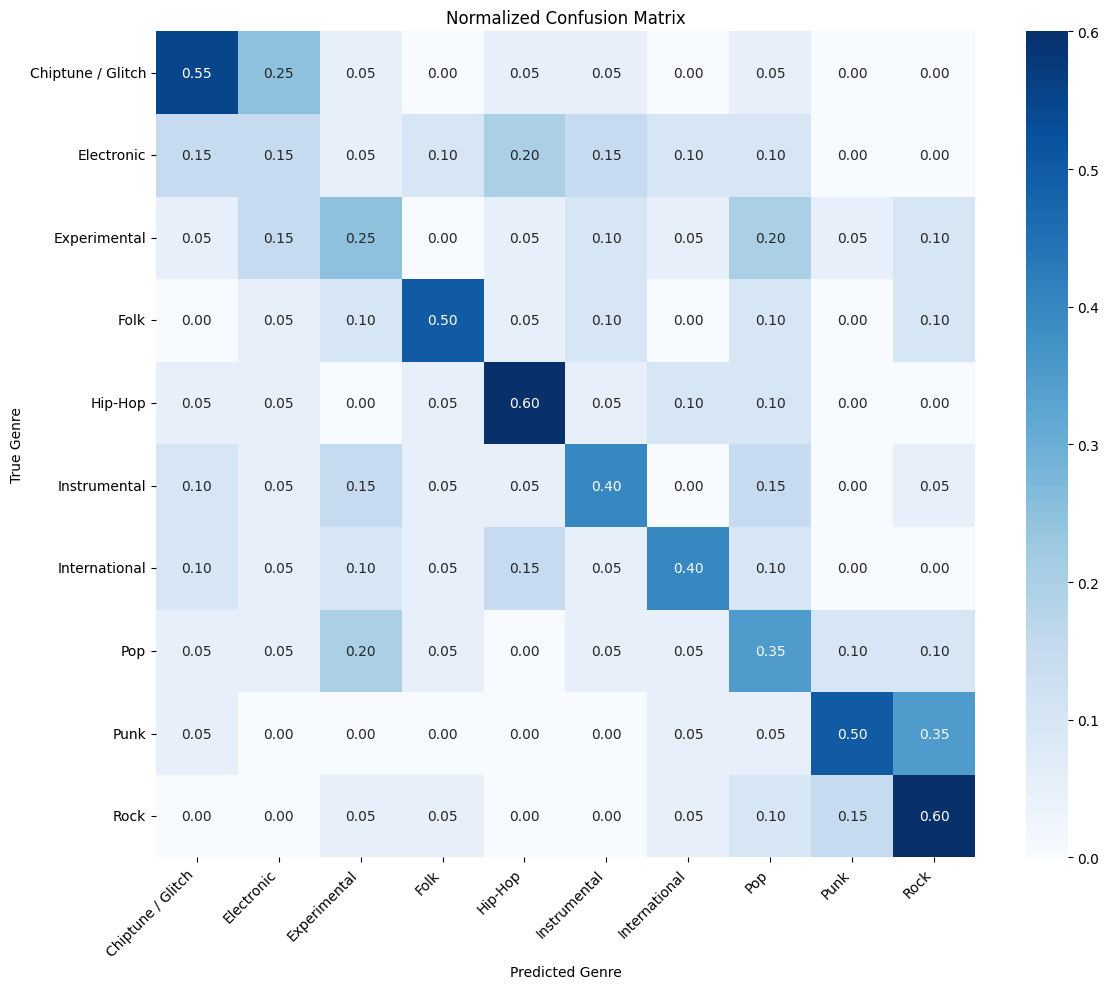

In [87]:
# Start training
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=100)

## 6. Evaluation and Confusion Matrix
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Genre")
    plt.ylabel("True Genre")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Load best model and plot confusion matrix
model.load_state_dict(torch.load("best_model.pth"))
plot_confusion_matrix(model, test_loader)